In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [2]:
DEBUG = False

# Strategies

In [3]:
# Abstract Class for Strategy.
class Strategy(ABC):
    @abstractmethod
    def move(self, own_history, opponent_history):
        pass

In [4]:
class ListRepeatedStrategy(Strategy):
    def __init__(self, moves = ['C','C','D']):
        self.moves = moves
        self.current_index = 0

    def move(self, own_history, opponent_history):
        move = self.moves[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.moves)
        return move

In [5]:
# Naively faithful player (always chooses C)
class AlwaysCooperateStrategy(Strategy):
    def move(self, own_history=[], opponent_history=[]):
        move = "C"
        return move

In [6]:
# Always chooses D
class AlwaysDefectStrategy(Strategy):
    def move(self, own_history, opponent_history):
        move = "D"
        return move

In [7]:
# Alternating choices between C and D
class AlternatingStrategy(Strategy):
    def move(self, own_history, opponent_history):
        if not own_history or own_history[-1] == "D":
            move = "C"
        else:
            move = "D"
        return move

In [8]:
class RandomStrategy(Strategy):
    def move(self, own_history, opponent_history):
        move = random.choice(["C", "D"])
        return move

In [9]:
# Special class of adaptive players who weighs the expected score for each decision (over opponent's history)
class AdaptiveStrategy(Strategy):
    def move(self, own_history, opponent_history):
        # percentage of cooperative decisions in opponent's history
        if len(opponent_history) != 0:
            opponent_fidelity = opponent_history.count("C") / len(opponent_history)
        else:
            opponent_fidelity = 1  # assume the best in people
        reward_C = opponent_fidelity * 3 + (1 - opponent_fidelity) * 0
        reward_D = opponent_fidelity * 5 + (1 - opponent_fidelity) * 1

        if reward_C > reward_D:
            move = "C"
        else:
            move = "D"
        return move

# Strategy Switchers

In [10]:
class StrategySwitcher(ABC):
    @abstractmethod
    def check(self, agent, opponent_history):
        pass

In [11]:
class NOPSwitcher(StrategySwitcher):
    def check(self, agent, opponent_history):
        return False, None

In [12]:
class SoftMajor(StrategySwitcher):   
    def check(self, agent, opponent_history, neighbors):
        nb_strat_names = []
        for nb in neighbors:
            nb_strat_names.append(nb.strategy.__class__.__name__)

        count = {}
        for string in nb_strat_names:
            count[string] = count.get(string, 0) + 1
        if DEBUG:
            print("Whole list: ",nb_strat_names)
        # Find the most frequent string
        most_frequent = max(count, key=count.get)
        if DEBUG:
            print("Most frequent: ",most_frequent)

        # Dynamically instantiate the class based on the most frequent string
        try:
            return True, eval(most_frequent + "()")
        except NameError:
            print("Something wrong with my neighbors!")
            return False, None     
        

In [13]:
class RandomSwitcher(StrategySwitcher):
    def check(self, agent, opponent_history):
        pool_of_strats = ['AlwaysCooperateStrategy', 'AlwaysDefectStrategy', 'ListRepeatedStrategy'\
                  ,'RandomStrategy', 'AdaptiveStrategy']
        return True, eval(random.choice(pool_of_strats)+'()')

In [14]:
class TitForTat(StrategySwitcher):
    def check(self, agent, opponent_history):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]

        if (
            opponent_history
            and opponent_history[-1] == "D"
            and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
        ):
            return True, AlwaysDefectStrategy()
        elif (
            opponent_history
            and opponent_history[-1] == "C"
            and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy"
        ):
            return True, AlwaysCooperateStrategy()

        return False, None

In [15]:
class CooperateUntilNDefectionsInARow(StrategySwitcher):
    def __init__(self, n_defections_threshold):
        self.n_defections_threshold = n_defections_threshold
        self.n_defections_in_a_row = 0
        self.threshold_hit = False

    def check(self, agent, opponent_history):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.n_defections_in_a_row >= 0

        if opponent_history and opponent_history[-1] == "D":
            self.n_defections_in_a_row += 1
        else:
            self.n_defections_in_a_row = 0

        if (
            not self.threshold_hit
            and self.n_defections_in_a_row >= self.n_defections_threshold
        ):
            self.threshold_hit = True

        if (
            agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
            and self.threshold_hit
        ):
            return True, AlwaysDefectStrategy()

        return False, None

In [16]:
class RetaliateWithTwoDefections(StrategySwitcher):
    def __init__(self):
        self.retaliations_left = 0
        super().__init__()

    def check(self, agent, opponent_history):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.retaliations_left >= 0

        if self.retaliations_left > 0:
            self.retaliations_left -= 1

        if opponent_history and opponent_history[-1] == "D":
            self.retaliations_left += 2

        if (
            self.retaliations_left > 0
            and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
        ):
            return True, AlwaysDefectStrategy()
        elif (
            self.retaliations_left == 0
            and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy"
        ):
            return True, AlwaysCooperateStrategy()

        return False, None

# Player

In [17]:
@dataclass
class PlayerMoveTally():
    cooperations: int = 0
    defections: int = 0

    def update(self, move):
        if move == 'C':
            self.cooperations += 1
        elif move == 'D':
            self.defections += 1
        else:
            raise ValueError(f"Move must be either 'C' or 'D', got {move}")

    def __add__(self, other):
        return PlayerMoveTally(
            cooperations=self.cooperations + other.cooperations,
            defections=self.defections + other.defections,
        )

    def __str__(self):
        return f"Cooperations: {self.cooperations}, Defections: {self.defections}"

In [18]:
# Generic class for any Player (next block we shall define inherited classes with specific strategies)
class Player:
    def __init__(self, strategy, strategy_switcher, neighbors=[]):
        self.history = []
        self.strategy = strategy
        self.strategy_switcher = strategy_switcher
        self.neighbors = []
        self.neighbor_tallies = {}

        self.add_neighbors(neighbors)

    def add_neighbors(self, neighbors):
        assert isinstance(neighbors, list), f"Expected a list of neighbors, got {type(neighbors)}"

        for neighbor in neighbors:
            if neighbor not in self.neighbors:
                self.neighbors.append(neighbor)
                self.neighbor_tallies[neighbor.id] = PlayerMoveTally()

    def gather_opponent_tally(self, opponent):
        opponent_tally = self.neighbor_tallies.get(opponent.id, PlayerMoveTally())

        if DEBUG:
            print(f"Player {self.id} gathering opponent tally for {opponent.id}")
            print(f"Knows '{opponent_tally}' so far")

        for neighbor in self.neighbors:
            if neighbor.id == opponent.id:
                continue

            neighbor_info = neighbor.neighbor_tallies.get(opponent.id, PlayerMoveTally())
            opponent_tally += neighbor_info

            if DEBUG:
                print(f"\tGot '{neighbor_info}' from {neighbor.id}")
                print(f"\tUpdated tally to '{opponent_tally}'")

        return opponent_tally

    def update_tally(self, opponent, opponent_move):
        self.neighbor_tallies[opponent.id].update(opponent_move)

    def check_should_switch_strategy(self, opponent_history):
        if self.strategy_switcher.__class__.__name__ == 'SoftMajor':
            should_switch_strategy, next_strategy = self.strategy_switcher.check(self, opponent_history, self.neighbors)
        else:
            should_switch_strategy, next_strategy = self.strategy_switcher.check(self, opponent_history)
        if should_switch_strategy:
            self._switch_strategy(next_strategy)

    def play(self, opponent_history):
        decision = self.strategy.move(self.history, opponent_history)
        self.update_history(decision)
        return decision

    def update_history(self, own_move):
        self.history.append(own_move)

    def latest_move(self):
        return self.history[-1]

    def reset(self):
        self.history = []

    def _switch_strategy(self, new_strategy):
        self.strategy = new_strategy

# Helper Functions

In [19]:
# Define a typical Prisoner's Dilemma payoff matrix
PAYOFF_MATRIX = {
    'C': {'C': (3, 3), 'D': (0, 5)},
    'D': {'C': (5, 0), 'D': (1, 1)}
}

# Simulation Test

In [20]:
# # Block of code for visualization (export a .gif for now)

# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter


# sums_along_first_axis = np.sum(np.abs(data), axis=(1, 2))
# last_nonzero_slice = np.max(np.nonzero(sums_along_first_axis))
# data_truncate = data[: last_nonzero_slice + 1]

# fig, ax = plt.subplots()
# plt.axis("off")

# # Setting up the colormap - you can choose your own colors
# cmap = plt.get_cmap("RdYlBu")
# norm = plt.Normalize(-1, 1)


# def update(frame):
#     ax.clear()
#     ax.imshow(data_truncate[frame], cmap=cmap, norm=norm)
#     ax.set_title(f"Time step: {frame}")


# ani = FuncAnimation(fig, update, frames=data_truncate.shape[0], repeat=True)
# # plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))

# # Save as GIF
# ani.save("animation.gif", writer=PillowWriter(fps=1))

# # Show the animation
# plt.show()

# Network Generator

In [21]:
@dataclass
class Edge:
    x1: int
    y1: int
    x2: int
    y2: int

    @classmethod
    def from_indices(cls, index1, index2, width):
        x1, y1 = index1 // width, index1 % width
        x2, y2 = index2 // width, index2 % width
        return cls(x1, y1, x2, y2)

    def __str__(self):
        return f"({self.x1}, {self.y1}) -> ({self.x2}, {self.y2})"

In [22]:
@dataclass
class NetworkPosition:
    x: int
    y: int

    @classmethod
    def from_index(cls, index, width):
        return cls(index // width, index % width)

    def to_index(self, width):
        return self.x * width + self.y

    def __str__(self):
        return f"({self.x}, {self.y})"

In [23]:
class Network:
    def __init__(self, N, M, Ntype="Lattice", density=0, spread=0):
        assert Ntype in ["Graph", "Lattice", "CLattice"]
        self.dim = (N, M)
        self.sz = N * M
        self.type = Ntype
        self.density = density
        self.spread = spread

    def generate(self):
        self.l = [[0 for _ in range(self.sz)] for _ in range(self.sz)]
        self.edges = []

        if self.type == "Graph":
            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj = random.randrange(0, self.sz * self.sz)
                u, v = edj % self.sz, edj // self.sz
                if u == v or self.l[u][v] > 0:
                    continue
                self.l[u][v] = self.l[v][u] = 1
                cnt = cnt + 1

        elif self.type == "Lattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

        elif self.type == "CLattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj1 = random.randrange(0, self.sz)
                u1, v1 = edj1 // self.dim[1], edj1 % self.dim[1]
                u2, v2 = round(random.gauss(u1, self.spread)), round(random.gauss(v1, self.spread))
                if (u1 == u2 and v1 == v2) or u2 < 0 or u2 >= self.dim[0] or v2 < 0 or v2 >= self.dim[1]:
                    continue
                edj2 = u2 * self.dim[1] + v2
                if self.l[edj1][edj2] > 0:
                    continue
                self.l[edj1][edj2] = self.l[edj2][edj1] = 1
                cnt = cnt + 1

        for i in range(self.sz):
            for j in range(i + 1, self.sz):
                if self.l[i][j]:
                    self.edges.append(
                        Edge.from_indices(i, j, self.dim[1])
                    )

        self.E = len(self.edges)

    def getEdges(self, from_position):
        eList = []
        for v in range(0, self.sz):
            if self.l[from_position.to_index(self.dim[1])][v] == 1:
                eList.append(
                    NetworkPosition.from_index(v, self.dim[1])
                )

        return eList

    def printNet(self):
        print("|V| = " + str(self.sz) + "; |E| = " + str(self.E))
        for u in range(self.sz):
            at = NetworkPosition.from_index(u, self.dim[1])
            print(f"{at}: ", end="")
            lst = self.getEdges(at)
            for network_position in lst:
                print(f" {network_position}", end="")
            print()

In [24]:
net1 = Network(5, 5, "Lattice")
net1.generate()
net1.printNet()
assert net1.E == 40

|V| = 25; |E| = 40
(0, 0):  (0, 1) (1, 0)
(0, 1):  (0, 0) (0, 2) (1, 1)
(0, 2):  (0, 1) (0, 3) (1, 2)
(0, 3):  (0, 2) (0, 4) (1, 3)
(0, 4):  (0, 3) (1, 4)
(1, 0):  (0, 0) (1, 1) (2, 0)
(1, 1):  (0, 1) (1, 0) (1, 2) (2, 1)
(1, 2):  (0, 2) (1, 1) (1, 3) (2, 2)
(1, 3):  (0, 3) (1, 2) (1, 4) (2, 3)
(1, 4):  (0, 4) (1, 3) (2, 4)
(2, 0):  (1, 0) (2, 1) (3, 0)
(2, 1):  (1, 1) (2, 0) (2, 2) (3, 1)
(2, 2):  (1, 2) (2, 1) (2, 3) (3, 2)
(2, 3):  (1, 3) (2, 2) (2, 4) (3, 3)
(2, 4):  (1, 4) (2, 3) (3, 4)
(3, 0):  (2, 0) (3, 1) (4, 0)
(3, 1):  (2, 1) (3, 0) (3, 2) (4, 1)
(3, 2):  (2, 2) (3, 1) (3, 3) (4, 2)
(3, 3):  (2, 3) (3, 2) (3, 4) (4, 3)
(3, 4):  (2, 4) (3, 3) (4, 4)
(4, 0):  (3, 0) (4, 1)
(4, 1):  (3, 1) (4, 0) (4, 2)
(4, 2):  (3, 2) (4, 1) (4, 3)
(4, 3):  (3, 3) (4, 2) (4, 4)
(4, 4):  (3, 4) (4, 3)


In [25]:
net2 = Network(5, 5, "Graph", density=0.25)
net2.generate()
# net2.printNet()
assert net2.E == 75

In [26]:
net3 = Network(5, 5, "CLattice", density=0.04, spread=5)
net3.generate()
# net3.printNet()
assert net3.E == 52

# Simulator

In [27]:
class SimulatorPlayer(Player):
    next_id = 0

    def __init__(self):
        self.id = SimulatorPlayer.next_id
        SimulatorPlayer.next_id += 1

        super().__init__(None, None)

    def init(self, neighbors, player):
        if DEBUG:
            print(f"Initializing player {self.id}")

        self.add_neighbors(neighbors)
        self.history = player.history
        self.strategy = player.strategy
        self.strategy_switcher = player.strategy_switcher

    def play(self, opponent, opponent_history_snapshot):
        # TODO: Actually use info
        info = self.gather_opponent_tally(opponent)
        return super().play(opponent_history_snapshot)

In [28]:
class Simulator:
    def __init__(self, n, m, pm=PAYOFF_MATRIX):
        self.n = n
        self.m = m
        self.payoff_matrix = pm
        self.population = []
        self.cooperation_percentage = []

    def init_network(self, ntype="Lattice", density=0.0, spread=0.0):
        self.network = Network(self.n, self.m, ntype, density, spread)
        self.network.generate()

    def init_grid(self):
        self.grid = []
        for i in range(self.n):
            self.grid.append([])
            for j in range(self.m):
                self.grid[i].append(SimulatorPlayer())
        self.pairs = [
            (self.grid[edge.x1][edge.y1], self.grid[edge.x2][edge.y2])
            for edge in self.network.edges
        ]

    def set_player(self, i, j, player):
        ngbr_list = self.network.getEdges(NetworkPosition(i, j))
        ngbrs = [self.grid[network_position.x][network_position.y] for network_position in ngbr_list]
        self.grid[i][j].init(ngbrs, player)

    def match(self, p1, p2):
        p1_history_snapshot_len = len(p1.history)
        p2_history_snapshot_len = len(p2.history)

        move1 = p1.play(p2, p2.history[:p2_history_snapshot_len])
        move2 = p2.play(p1, p1.history[:p1_history_snapshot_len])

        p1.update_tally(p2, move2)
        p2.update_tally(p1, move1)

        p1.check_should_switch_strategy(p2.history[:p2_history_snapshot_len + 1])
        p2.check_should_switch_strategy(p1.history[:p1_history_snapshot_len + 1])

        score1, score2 = self.payoff_matrix[move1][move2]
        return score1, score2

    def round(self):
        scores = [[0 for _ in range(self.m)] for _ in range(self.n)]
        for i in range(len(self.pairs)):
            pair = self.pairs[i]
            edge = self.network.edges[i]
            score1, score2 = self.match(pair[0], pair[1])
            scores[edge.x1][edge.y1] += score1
            scores[edge.x2][edge.y2] += score2
        return scores

    def simulate(self, n_rounds=1):
        scores_history = []
        
        for _ in range(n_rounds):
            scores = self.round()
            scores_history.append(scores)
            self.population.append(self.count_strategies())

        return scores_history

    def count_strategies(self, strategy_classes=Strategy.__subclasses__()):
        strategy_counts = {name: 0 for name in [cls.__name__ for cls in strategy_classes]}

        agents = [agent for grid_line in self.grid for agent in grid_line]
        for agent in agents:
            for strategy_class in strategy_classes:
                if isinstance(agent.strategy, strategy_class):
                    strategy_counts[strategy_class.__name__] += 1
                    break

        return strategy_counts

    """
    TODO: Implementation of plot function for the simulation
    """
    def update_cooperation_rate(self, n_rounds):
        d = len(self.grid[0][0].history)/n_rounds
        for round in range(n_rounds):
            round_strings = []

            for i in range(self.n):
                for j in range(self.m):
                    start = int(round*d)
                    end = int(start + d)
                    player_string = self.grid[i][j].history[start:end]
                    round_strings += player_string

            self.cooperation_percentage.append(round_strings)

    def plot_cooperation(self, n_rounds):
        self.update_cooperation_rate(n_rounds)
        # Step 1: Calculate percentages per time step
        percentages = []
        for sublist in self.cooperation_percentage:
            count_C = sublist.count('C')
            total_count = len(sublist)
            percentage_C = count_C / total_count if total_count > 0 else 0
            percentages.append(percentage_C)

        # Step 2: Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(percentages, marker='o', linestyle='-')

        plt.xlabel('Virtual Time (rounds)')
        plt.ylabel('Percentage of Cooperation')
        plt.title('Percentage of Cooperation Over Time')
        plt.xticks(range(len(self.cooperation_percentage)))
        plt.grid(True)
        plt.show()

    def plot_evolution(self):
        # Convert to DataFrame
        df = pd.DataFrame(self.population)

        # Filter out columns (strategies) where all values are zero
        df = df.loc[:, (df != 0).any(axis=0)]

        # Plotting
        plt.figure(figsize=(10, 6))
        for column in df.columns:
            plt.plot(df[column], marker='o', label=column)
            # plt.plot(df.index, df[column], marker='o', label=column)
        
        plt.xlabel('Virtual Time (rounds)')
        plt.ylabel('Strategy Value')
        plt.title('Evolution of Strategies Over Time')
        plt.xticks(range(len(df)))
        plt.legend()
        plt.grid(True)
        plt.show()
        return None

In [29]:
# Example
pool_of_strats = ['AlwaysCooperateStrategy', 'AlwaysDefectStrategy', 'ListRepeatedStrategy'\
                  ,'RandomStrategy', 'AdaptiveStrategy']
pool_of_switchers = ['NOPSwitcher', 'SoftMajor', 'RandomSwitcher']
num_rounds = 20
grid_size = 50
s = Simulator(grid_size,grid_size)
s.init_network("Lattice")
s.init_grid()
for i in range(grid_size):
    for j in range(grid_size):
        s.set_player(i, j, Player(eval(random.choice(pool_of_strats) + '()')\
                                  , eval(random.choice(pool_of_switchers) + '()')))
score_hist = s.simulate(n_rounds=num_rounds)

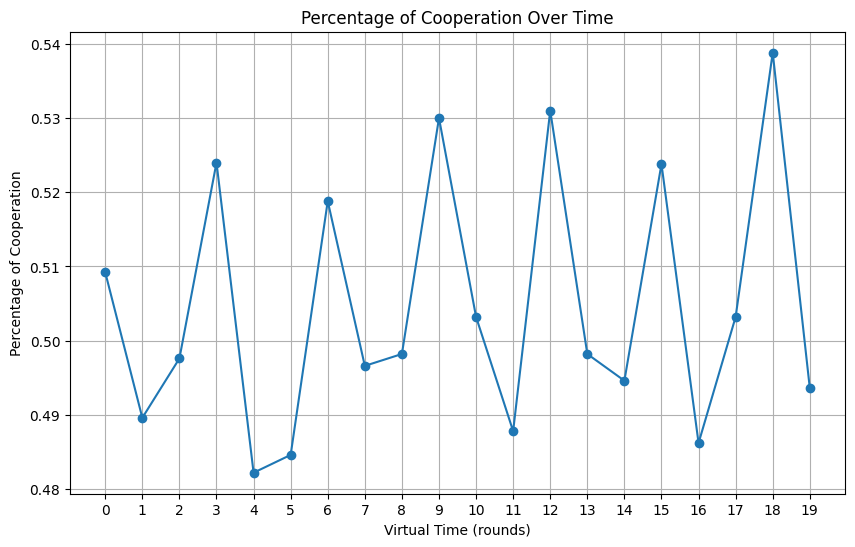

In [30]:
s.plot_cooperation(num_rounds)

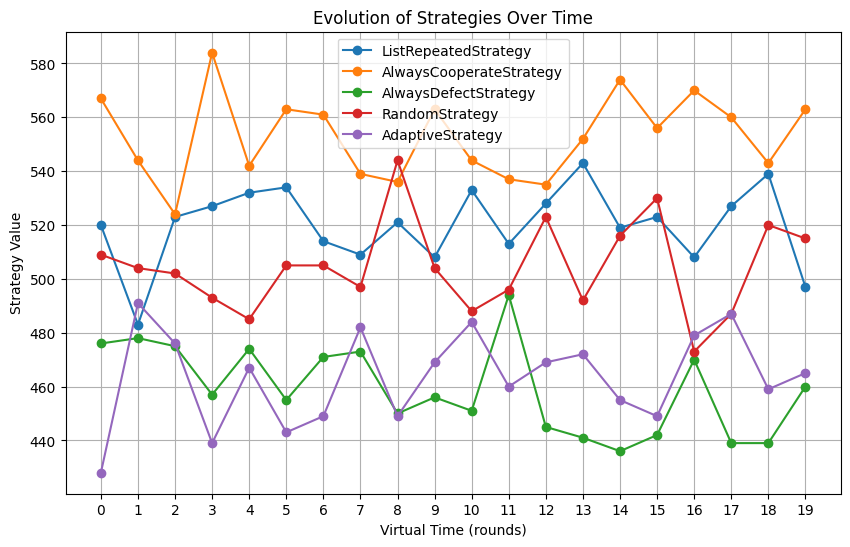

In [31]:
s.plot_evolution()

# Tests

In [32]:
# print("Test CooperateUntilNDefectionsInARow")
# lattice = [
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=1),
#     ),
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
# ]
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [33]:
# print("Test CooperateUntilNDefectionsInARow (N = 1)")
# lattice = [
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=1),
#     ),
# ]
# assert lattice[1].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[1].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [34]:
# print("Test CooperateUntilNDefectionsInARow (N = 2)")
# lattice = [
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=2),
#     ),
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
# ]
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [35]:
# print("Test TitForTat")
# opponent_moves = ["C", "D", "D", "C", "C", "D"]
# lattice = [
#     Player(AlwaysCooperateStrategy(), TitForTat()),
#     Player(ListRepeatedStrategy(opponent_moves), NOPSwitcher()),
# ]

# for i in range(len(opponent_moves)):
#     expected_strategy_before = (
#         "AlwaysDefectStrategy"
#         if i - 1 >= 0 and opponent_moves[i - 1] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_before
#     play_game(lattice[0], lattice[1], 1, offset=i)
#     expected_strategy_after = (
#         "AlwaysDefectStrategy"
#         if opponent_moves[i] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_after
# print("Passed")

In [36]:
# print("Test RetaliateWithTwoDefections")
# expected_moves = ["C", "C", "D", "D", "C", "C", "D", "D", "D", "D", "C", "C"]
# opponent_moves = ["C", "D", "C", "C", "C", "D", "D", "C", "C", "C", "C", "C"]
# lattice = [
#     Player(AlwaysCooperateStrategy(), RetaliateWithTwoDefections()),
#     Player(ListRepeatedStrategy(opponent_moves), NOPSwitcher()),
# ]

# for i in range(len(opponent_moves)):
#     expected_strategy_before = (
#         "AlwaysDefectStrategy"
#         if expected_moves[i] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_before
#     play_game(lattice[0], lattice[1], 1, offset=i)
# print("Passed")